In [1]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import numpy as np

#Import library code
import helper_code.dataloading as dataloading
import helper_code.model_functions as model_functions
import helper_code.data_vis as data_vis

2025-12-05 03:04:54.360288: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
labels_csv = "camera_data/coronado_hills_binary_10-24-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [3]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [4]:
train['label'].value_counts() / len(train['label'])

label
0    0.518692
1    0.481308
Name: count, dtype: float64

In [5]:
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="val_embeddings")

In [6]:
db_output = collection.get(ids = val['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = val['label']

In [7]:
db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

In [8]:
db_df = db_df.merge(val, left_on = 'ids', right_on='annotation_id')

In [9]:
embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']
img_urls = db_df['img_url']
a_ids = db_df['annotation_id']

In [10]:
embeddings

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,1.044697,0.843883,0.111647,0.016429,-1.102493,-0.174548,0.994675,-0.219120,-1.740564,-1.561615,...,0.668836,0.080094,0.493067,0.059865,0.521551,0.542481,-1.339480,0.107565,0.804884,0.063190
1,0.606504,-0.001289,-0.210424,1.008094,0.010629,0.144950,0.561155,0.275140,-1.042764,-0.738244,...,0.974300,0.253672,0.076933,-0.053054,-0.455533,-0.104984,-1.366687,-0.724373,0.727745,-1.682427
2,0.416794,-0.266992,-0.076891,0.916836,-0.397167,0.640760,-0.211616,0.165019,-1.187046,-1.433305,...,1.376972,0.238108,0.246177,-0.485932,-0.327444,0.040696,-1.300251,-0.509319,1.090501,-1.687646
3,1.000028,1.074548,-0.766767,-0.281090,-1.251420,-0.134055,0.792077,-0.372376,-1.358609,-1.862313,...,0.555476,0.049911,0.242850,0.033720,0.467660,0.872225,-1.382048,0.304678,1.250181,-0.510854
4,1.057167,0.833377,-0.564726,-0.342505,-0.984944,-0.009359,0.561099,-0.220529,-1.608331,-1.722088,...,0.670818,0.077352,0.424890,0.185064,0.372354,1.005897,-1.509293,-0.042266,1.435282,-0.875281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1493,0.318776,-0.172444,-0.330744,1.135173,-0.152763,0.679779,0.086271,0.178206,-1.471063,-1.322357,...,1.529482,0.246524,0.275957,-0.416837,-0.762410,0.278614,-1.431072,-0.639726,0.862482,-1.952956
1494,0.969549,0.102790,0.002098,0.475727,-0.332012,0.294751,0.271967,-0.031732,-1.807161,-1.198722,...,1.070470,0.153597,0.405329,-0.200817,-0.242317,0.887062,-1.541718,-0.368466,1.070212,-1.341153
1495,1.074331,0.940450,-0.379401,-0.351035,-1.086676,-0.093555,0.937402,-0.484567,-1.737268,-1.801877,...,0.805853,0.068297,0.678145,0.080228,0.661184,0.725193,-1.568299,0.184115,1.235241,-0.461590
1496,0.865324,0.918083,-0.514315,-0.383347,-1.144104,-0.220402,0.743186,-0.436532,-1.456573,-1.662477,...,0.583276,0.050441,0.323615,0.144753,0.402323,0.871137,-1.257086,0.359241,1.289182,-0.376180


In [11]:
reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels)


In [12]:
data_vis.save_embeddings_to_json(reduced_embeddings, labels, img_urls, a_ids)

saved embeddings to embedding_data/d3_data.json!


In [13]:
df = pd.DataFrame({
    "x": reduced_embeddings[:,0],
    "y": reduced_embeddings[:,1],
    "label": labels,
    "a_id": val['annotation_id'] 
})

color_map = {0: 'purple', 1: 'gold'}
df['color'] = df['label'].map(color_map)

X = df['x'].values
y = df['label'].values
ids = df['a_id'].values

# find best threshold for desicion stump on x-axis

thresholds = np.unique(X)
best_acc = 0
best_thresh = None
likely_mislabeled = []

for t in thresholds:

    pred1 = (X >= t).astype(int) 
    pred2 = (X < t).astype(int)

    acc1 = (pred1 == y).mean()
    acc2 = (pred2 == y).mean()

    if acc1 > best_acc:
        best_acc = acc1
        best_thresh = t
        likely_mislabeled = ids[pred1 != y]
    if acc2 > best_acc:
        best_acc = acc2
        best_thresh = t
        likley_mislabeled = ids[pred2 != y]

print(f"best threshold: {best_thresh}, accuracy: {best_acc:.3f}")
print("likley mislabeled points:", likley_mislabeled)

best threshold: -4.197607550646328, accuracy: 0.876
likley mislabeled points: [40901 33304 37219 40089 38396 35218 33145 40463 34213 40902 37790 36389
 34194 34650 34050 37171 40311 35173 38360 34243 34133 37604 40251 34692
 32178 33905 34832 36922 34135 31883 31672 40621 40604 33770 40500 39741
 37350 36779 31948 40257 38009 39469 33587 37914 34304 39780 36825 36726
 35191 39670 34459 36962 33360 38191 37287 37283 33054 34210 39746 33621
 39662 35421 39403 40146 36941 37285 34962 37271 36336 36751 35135 33045
 38096 31735 32245 34613 36710 34083 32042 34072 39888 34657 36695 32050
 32880 38369 34878 36951 38374 40551 38288 31708 36942 37477 33271 37121
 33404 33578 35208 34032 33667 35068 31940 32199 39849 37167 36869 33536
 39698 36466 37680 32502 33096 36812 33359 39639 38181 36928 32241 34806
 38245 31980 39661 32204 37578 33513 37103 32525 37734 40313 33219 34704
 36585 40883 34866 40087 31837 39243 33817 37109 34765 39951 34261 34949
 35150 35169 32183 34973 35381 37443 35087 405

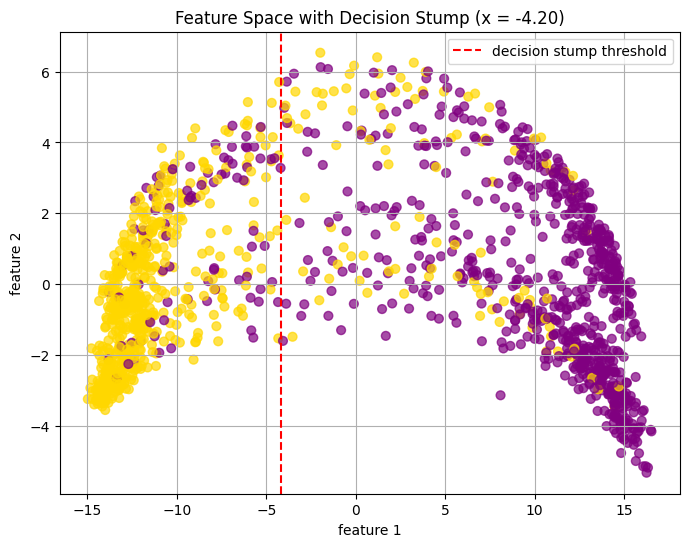

In [14]:
plt.figure(figsize=(8,6))
plt.scatter(df['x'], df['y'], c=df['color'], s=40, alpha=0.7)
plt.axvline(best_thresh, color='red', linestyle='--', label='decision stump threshold')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title(f"Feature Space with Decision Stump (x = {best_thresh:.2f})")
plt.legend()
plt.grid(True)
plt.show()

In [15]:
data_vis.plot_data(reduced_embeddings, labels, pc1=1, pc2=2)
data_vis.format_plot('PCA Reduced Embeddings', 'Principal Component 1', 'Principal Component 2')

TypeError: plot_data() got an unexpected keyword argument 'pc1'

Accuracy: 0.8751668891855807


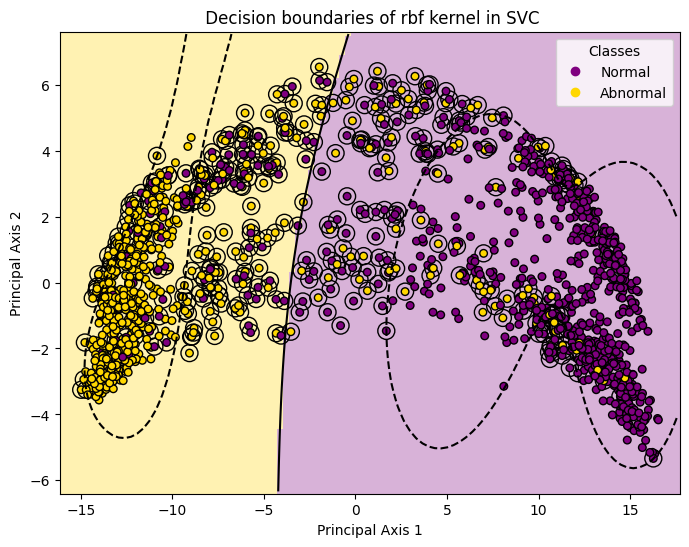

In [16]:
svm_classifier = data_vis.plot_with_decision_boundary("rbf", reduced_embeddings, labels)

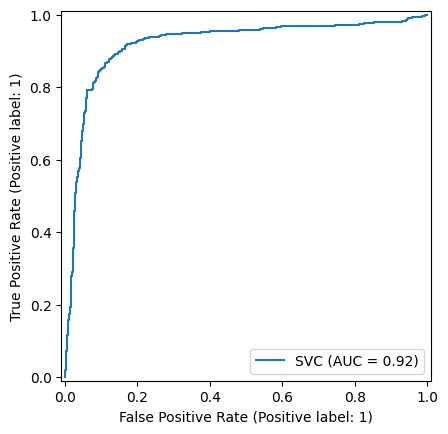

In [17]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, reduced_embeddings, labels)

plt.show()

In [18]:
from sklearn.decomposition import PCA

# Make sure `embeddings` is a 2D array / DataFrame of shape (n_samples, 768)
X = np.array(embeddings)

pca = PCA(n_components=8, random_state=42)
pcs = pca.fit_transform(X)

pc_cols = [f"PC{i}" for i in range(1, pcs.shape[1] + 1)]
pc_df = pd.DataFrame(pcs, columns=pc_cols)

# Attach label + image info so we can color/stratify plots
pc_df = pd.concat(
    [
        pc_df.reset_index(drop=True),
        db_df[['label', 'img_url', 'annotation_id']].reset_index(drop=True)
    ],
    axis=1
)

pc_df.head()


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,label,img_url,annotation_id
0,9.581311,0.111907,-3.359137,0.669091,2.062946,-1.397760,-0.875083,2.307650,0,https://tools.alertcalifornia.org/fireframes5/...,33808
1,-13.706028,-2.759424,-0.096040,1.934319,-0.870800,0.837967,-0.735850,-0.294965,1,https://tools.alertcalifornia.org/fireframes5/...,39882
2,-11.241792,2.584738,0.537251,-1.833964,-0.458596,-0.266277,-1.622078,-1.558316,1,https://tools.alertcalifornia.org/fireframes5/...,32374
3,11.339468,3.104859,1.781200,1.185498,0.461312,1.023393,-0.808464,-0.299926,0,https://tools.alertcalifornia.org/fireframes5/...,36767
4,7.662381,2.891438,1.154721,0.790284,0.245400,1.013665,1.705224,0.926664,1,https://tools.alertcalifornia.org/fireframes5/...,32817


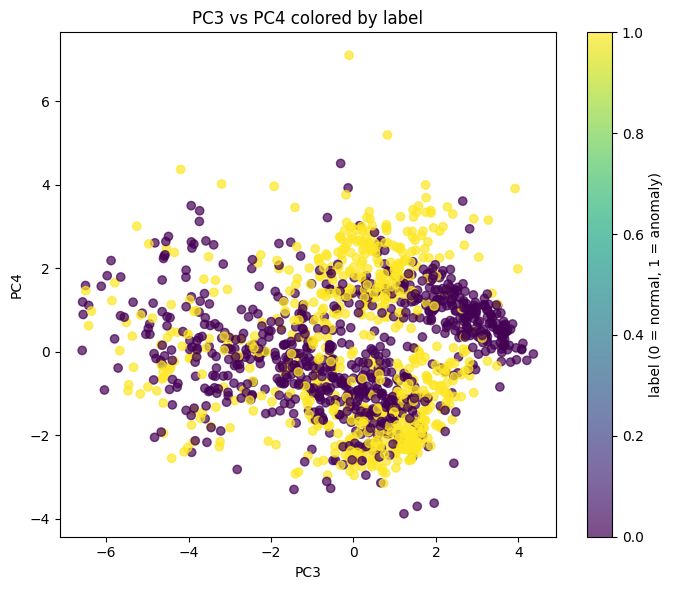

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    pc_df["PC3"],
    pc_df["PC4"],
    c=pc_df["label"],
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(scatter, label="label (0 = normal, 1 = anomaly)")
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.title("PC3 vs PC4 colored by label")
plt.tight_layout()
plt.show()


Kept 400 images with valid stats out of 400 sampled.
Correlation of PC3/PC4 with brightness / contrast / hue / saturation:

                 PC3       PC4
brightness -0.591967  0.035144
contrast   -0.498870  0.166803
hue_mean   -0.577275  0.064844
sat_mean   -0.550384  0.152235


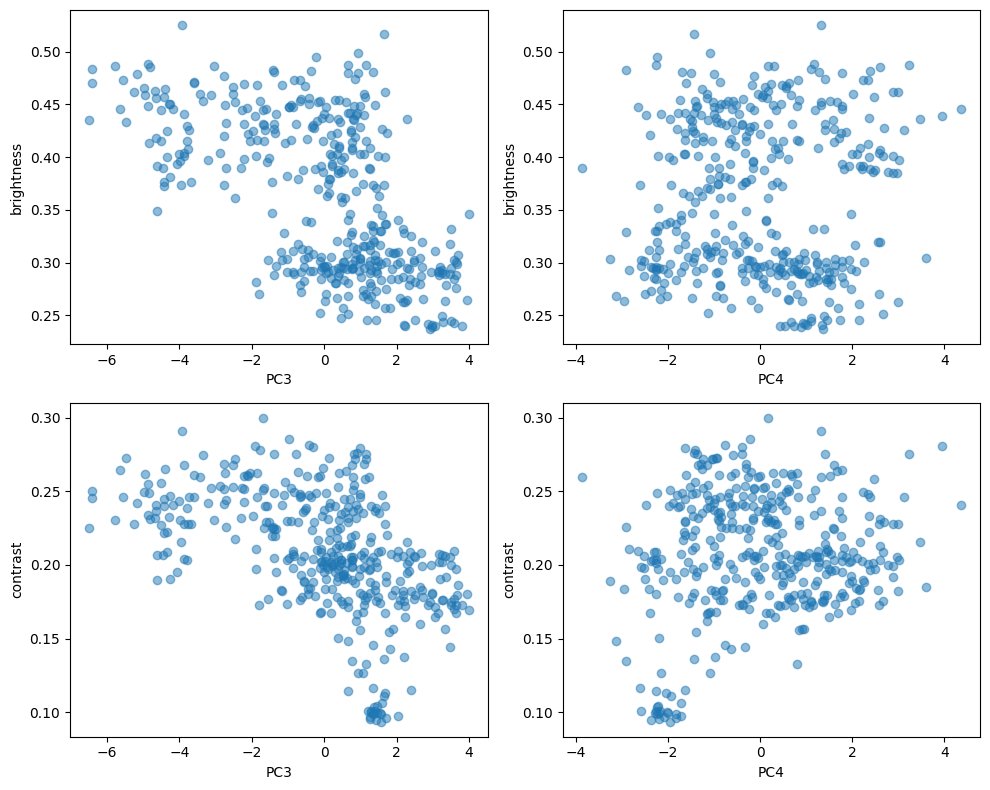

In [20]:
import requests
from io import BytesIO
from PIL import Image
from matplotlib import colors as mpl_colors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. Work on a subset so you don't hammer the server ----
sample_size = min(400, len(pc_df))   # tweak if you want more/less
sampled = pc_df.sample(n=sample_size, random_state=0).copy()

# ---- 2. Function to compute image stats from URL ----
def compute_img_stats_from_url(url: str):
    try:
        # download image
        resp = requests.get(url, timeout=5)
        resp.raise_for_status()

        img = Image.open(BytesIO(resp.content)).convert("RGB")
        arr = np.asarray(img, dtype=np.float32) / 255.0  # (H, W, 3) in [0,1]

        # basic luminance/contrast
        brightness = float(arr.mean())
        contrast = float(arr.std())

        # hue / saturation from HSV
        flat_rgb = arr.reshape(-1, 3)
        flat_hsv = mpl_colors.rgb_to_hsv(flat_rgb)
        hue_mean = float(flat_hsv[:, 0].mean())
        sat_mean = float(flat_hsv[:, 1].mean())

        return pd.Series(
            {
                "brightness": brightness,
                "contrast": contrast,
                "hue_mean": hue_mean,
                "sat_mean": sat_mean,
            }
        )
    except Exception as e:
        # if anything goes wrong, return NaNs so we can filter later
        return pd.Series(
            {
                "brightness": np.nan,
                "contrast": np.nan,
                "hue_mean": np.nan,
                "sat_mean": np.nan,
            }
        )

# ---- 3. Apply to the sample ----
stats = sampled["img_url"].apply(compute_img_stats_from_url)
sampled = pd.concat([sampled.reset_index(drop=True), stats.reset_index(drop=True)], axis=1)

# Drop rows where download failed
sampled = sampled.dropna(subset=["brightness", "contrast", "hue_mean", "sat_mean"])
print(f"Kept {len(sampled)} images with valid stats out of {sample_size} sampled.")

# ---- 4. Correlation of PC3/PC4 with image features ----
cols = ["PC3", "PC4", "brightness", "contrast", "hue_mean", "sat_mean"]
corr = sampled[cols].corr()

print("Correlation of PC3/PC4 with brightness / contrast / hue / saturation:\n")
print(corr.loc[["brightness", "contrast", "hue_mean", "sat_mean"], ["PC3", "PC4"]])

# ---- 5. Optional: quick visualization ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].scatter(sampled["PC3"], sampled["brightness"], alpha=0.5)
axes[0, 0].set_xlabel("PC3")
axes[0, 0].set_ylabel("brightness")

axes[0, 1].scatter(sampled["PC4"], sampled["brightness"], alpha=0.5)
axes[0, 1].set_xlabel("PC4")
axes[0, 1].set_ylabel("brightness")

axes[1, 0].scatter(sampled["PC3"], sampled["contrast"], alpha=0.5)
axes[1, 0].set_xlabel("PC3")
axes[1, 0].set_ylabel("contrast")

axes[1, 1].scatter(sampled["PC4"], sampled["contrast"], alpha=0.5)
axes[1, 1].set_xlabel("PC4")
axes[1, 1].set_ylabel("contrast")

plt.tight_layout()
plt.show()


Principal Component 3 appears to encode global image visibility and clarity.
PC3 shows strong negative correlations with brightness (–0.53), contrast (–0.48), color saturation (–0.52), and hue variation (–0.50). This suggests that PC3 increases when images are darker, less colorful, and lower-contrast, consistent with conditions such as fog, haze, nighttime, rain, or other forms of environmental degradation that reduce camera visibility.

Principal Component 4 shows only weak correlations with these image-level statistics, indicating it captures a more subtle structural or geometric feature of the scene rather than a simple illumination or color-based quality.